<a href="https://colab.research.google.com/github/peisuke/generative_ai_notebooks/blob/main/Vision/09_ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Googleドライブのマウント
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install -q diffusers==0.24.0 transformers xformers accelerate controlnet_aux omegaconf pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 M

In [3]:
!mkdir -p ckpt
!wget https://huggingface.co/xyn-ai/anything-v4.0/resolve/main/anything-v4.5-pruned.safetensors -O ckpt/Anything-v4.5-pruned.safetensors
!wget https://huggingface.co/ckpt/anything-v4.0/resolve/main/anything-v4.0.vae.pt -O ckpt/Anything-v4.0.vae.pt
!wget https://huggingface.co/comfyanonymous/ControlNet-v1-1_fp16_safetensors/resolve/main/control_v11p_sd15_scribble_fp16.safetensors \
    -O ckpt/control_v11p_sd15_scribble_fp16.safetensors

--2023-12-18 09:12:33--  https://huggingface.co/xyn-ai/anything-v4.0/resolve/main/anything-v4.5-pruned.safetensors
Resolving huggingface.co (huggingface.co)... 13.33.33.110, 13.33.33.102, 13.33.33.55, ...
Connecting to huggingface.co (huggingface.co)|13.33.33.110|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/74/9d/749dabe03ea9401d343e223bcd67528a5a96146fe57ad607f61d82ab2d726f32/6e430eb51421ce5bf18f04e2dbe90b2cad437311948be4ef8c33658a73c86b2a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27anything-v4.5-pruned.safetensors%3B+filename%3D%22anything-v4.5-pruned.safetensors%22%3B&Expires=1703149953&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwMzE0OTk1M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83NC85ZC83NDlkYWJlMDNlYTk0MDFkMzQzZTIyM2JjZDY3NTI4YTVhOTYxNDZmZTU3YWQ2MDdmNjFkODJhYjJkNzI2ZjMyLzZlNDMwZWI1MTQyMWNlNWJmMThmMDRlMmRiZTkwYjJjYWQ

In [4]:
import torch
from diffusers.models import AutoencoderKL
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
controlnet = ControlNetModel.from_single_file(
    "ckpt/control_v11p_sd15_scribble_fp16.safetensors"
)

pipe = StableDiffusionControlNetPipeline.from_single_file(
    "ckpt/Anything-v4.5-pruned.safetensors",
    vae=AutoencoderKL.from_single_file("ckpt/Anything-v4.0.vae.pt"),
    controlnet=controlnet,
    load_safety_checker=False
)
pipe.to("cuda")

pipe = pipe.to("cuda")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
from PIL import Image
control_img = Image.open("/content/drive/MyDrive/AI/ControlNet/control_img.png")
control_img = control_img.resize((512, 512)).convert('RGB')

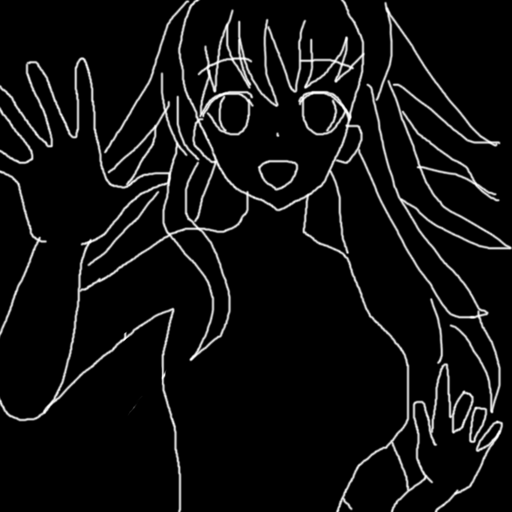

In [7]:
control_img

In [9]:
prompt = "1girl, green hair, sweater, looking at viewer, outdoors, watercolor, night, turtleneck,(waifu, anime, exceptional, best aesthetic, new, newest, best quality, masterpiece, extremely detailed:1.2)"
negative_prompt = "((bad hands)), ((mutated hands and fingers)), ((bad feet)), lowres, text, blurry, (ugly), logo, cropped, worst quality, jpeg, ((jpeg artifacts)), deleted, old, oldest, ((censored)), ((bad aesthetic)), (mosaic censoring, bar censor, blur censor), twitter username, watermark, low quality"

# 画像生成
image = pipe(
    prompt,
    control_img,
    negative_prompt=negative_prompt,
    generator=torch.Generator("cpu").manual_seed(42),
).images

  0%|          | 0/50 [00:00<?, ?it/s]

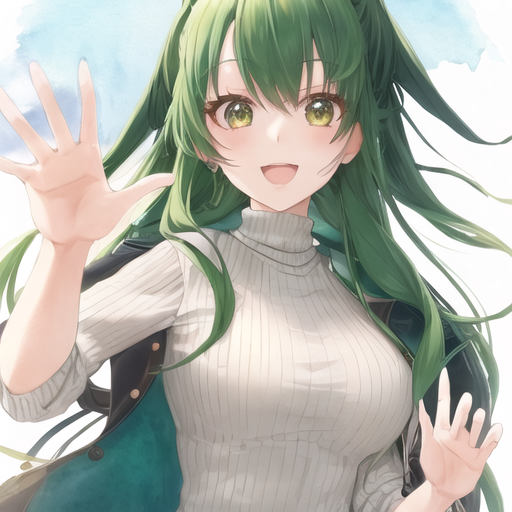

In [10]:
image[0]